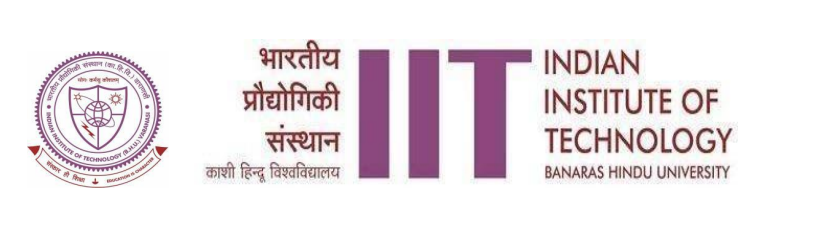
# **Exploratory Project**

Team Members:
1.   Anurag Chaudhary (20095012)
2.   Dipanshu Chaudhary (20095134)
3.   Jubin Banerjee (20095048)
4.   Tirumani Eshwar Sai Teja (20095117)

Performed uder the guidance of **Dr. Shivam Verma**





# **Image Colorization using GANs**

**Project Aim:**

> The aim is to colorize black and white images using tensorflow, Keras and 
a deep learning framework known as Generative adversarial network
(GAN’s)

GANs are the state-of-the-art machine learning models which can generate new data instances from existing ones. They use a very interesting technique, inspired from the Game Theory, to generate realistic samples.GANs are the state-of-the-art machine learning models which can generate new data instances from existing ones. They use a very interesting technique, inspired from the Game Theory, to generate realistic samples.

In this project we are going to demonstrate how we will use GANs to colorize B/W images. The model structure of our generator will be similar to that of a U-Net, i.e., one with skip connections



# **Step 1: Downloading and Preprocessing the data**

For our project, we are going to use a dataset containing 3000 RGB images. These images are going to be used to train our GANs model, where each image contains various scenes/places


*   Download the dataset from the github repository or from [here](https://drive.google.com/drive/folders/1dXnWUuM98b6KuoaO9tCw_1Y1ShPZ-XcT?usp=sharing)
*   Uploade the downloaded file here in the colab workspace



In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will now parse each RGB Image, one by one, and transform each one to grayscale format. For this purpose, we will use the PIL's .convert('L') method. Finally our dataset will have samples of (*grayscale image*, **RGB** image)

We have used only a part of the dataset using the dataset_split() method. This has been done as Colab's Computational power would cease on providing a large number of Images

In [15]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
import time
from tensorflow import keras
tf.config.run_functions_eagerly(True)

batch_size = 64
img_size = 120
dataset_split = 2500

In [16]:
master_dir = '/content/drive/MyDrive/img_color_data/data'
x = []
y = []

In [17]:
for image_file in os.listdir(master_dir)[0:dataset_split]:
  rgb_image = Image.open(os.path.join(master_dir, image_file)).resize((img_size, img_size))
  rgb_img_array = (np.asarray(rgb_image))/255
  gray_img = rgb_image.convert('L')
  gray_img_array = (np.asarray(gray_img).reshape((img_size, img_size, 1)))/255
  x.append(gray_img_array)
  y.append(rgb_img_array)

In [18]:
train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size = 0.1)

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)

# **Step 2: Creating the GAN Model**

## **A. Generator** 

Our generator ( represented as $G$ ) will take in a grayscale image $x$ and produce a RGB image $G( x )$. Note, $x$ will be a tensor of shape $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 1 \ )$ and the output $G(x)$ will have a shape $( \ batch \ size \ , \ 120 \ , \ 120 \ , \ 3 \ )$

* Our generator will have a encoder-decoder structure, similar to the UNet architecture. Additionally, we have used Dilated convolutions to have a larger receptive field.

* We introduce skip connections in our model so as to have better flow of information from the encoder to the decoder.

In [20]:
def get_generator_model():
  inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )
  conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
  conv1 = tf.keras.layers.LeakyReLU()( conv1 )
  conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
  conv1 = tf.keras.layers.LeakyReLU()( conv1 )
  conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
  conv1 = tf.keras.layers.LeakyReLU()( conv1 )

  conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
  conv2 = tf.keras.layers.LeakyReLU()( conv2 )
  conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
  conv2 = tf.keras.layers.LeakyReLU()( conv2 )
  conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
  conv2 = tf.keras.layers.LeakyReLU()( conv2 )

  conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
  conv3 = tf.keras.layers.LeakyReLU()( conv3 )
  conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
  conv3 = tf.keras.layers.LeakyReLU()( conv3 )
  conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
  conv3 = tf.keras.layers.LeakyReLU()( conv3 )

  bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

  concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
  conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
  conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
  conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

  concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
  conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
  conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
  conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

  concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
  conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
  conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
  conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

  model = tf.keras.models.Model( inputs , conv_up_1 )
  return model


## **B. Discriminator**

The discriminator model, represented as $D$, will take in the *real image* $y$ ( from the training data ) and the *generated image* $G(x)$ ( from the generator ) to output two probabilities.

* We train the discriminator in such a manner that is able to differentiate the *real images* and the generated *images*. So, we train the model such that $y$ produces a output of $1.0$ and $G(x)$ produces an output of $0.0$.
* Note that instead of using hard labels like $1.0$ and $0.0$, we use soft labels which are close to 1 and 0. So for a hard label of $1.0$, the soft label will be $(1 - \epsilon)$ where $\epsilon$ is picked uniformly from $( 0 , 0.1 ]$


In [21]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model

## **C. Loss Functions**

We'll now implement the loss functions for our GAN model.we have two loss functions, one for the generator and another for the discriminator. 

* For our generator, we have used the L2/MSE (Mean Squared Error) loss function.
* For our discriminator, we have used the Binary Cross Entropy Loss function.
* For optimization, we have use the Adam optimizer with a learning rate of 0.0005



In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()

# Step 3: Training our GAN Model

At this stage, we are going to start training our GAN model on the dataset that we prepared earlier

In [23]:
@tf.function
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


The Cell below starts the training of our GAN model

In [ ]:
num_epochs = 150
start = time.process_time()

for e in range( num_epochs ):
    print( e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print( x.shape )
        train_step( x , y )

print("Training Time: "+str(time.process_time()-start)+" seconds")       

Streaming output truncated to the last 5000 lines.
(64, 120, 120, 1)
(10, 120, 120, 1)
1
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(10, 120, 120, 1)
2
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120,

# Step 4: Results of our Model

We plotted the input(B/W image), output(GANs generated image), and the original coloured image from a part of the dataset, to view the final results

In [ ]:
y = generator( test_x[0 : ] ).numpy()

In [ ]:
acc = 0
for i in range(len(test_x)):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  diff = y[i] - test_y[i]
  diff = (sum(abs(diff)))/len(test_x)
  acc += diff

  plt.show()

# Conclusion:
By performing this project, we can clearly understand the power of GANs by these overwhelmingly accurate results.

In [ ]:
print("The accuracy of our model is : "+str(acc))